# Исследование данных о продаже компьютерных игр

**Цель исследования** — выполнить предобработку данных и изучить их, чтобы выявить определяющие успешность игры закономерности и спланировать дальнейшие рекламные кампании.

**Ход исследования**

Исторические данные до 2016 года о продажах игр, оценках пользователей и экспертов, жанрах и платформах мы получили из файла `/datasets/games.csv`. Данные за 2016 год могут быть неполными.

Исследование будет включать следующие этапы:
 1. [Обзор данных.](#info)
 2. [Предобработка данных](#preprocessing): изучим пропуски, проверим типы данных, устраним неявные дубликаты, а также редкие и выбивающиеся значения. 
 3. [Исследовательский анализ данных.](#eda)
 4. [Составим портрет пользователя для каждого региона.](#portrait)
 5. [Проверим гипотезы.](#hypotheses)

<a id="info"></a>
## Общая информация

In [2]:
#импортируем необходимые библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats as st

In [3]:
data = pd.read_csv('/datasets/games.csv', sep=',')

In [4]:
#посмотрим на первые 10 строк датафрейма
data.head(10)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


In [5]:
#изучим общую информацию
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


В таблице 11 столбцов. В столбцах присутствуют различные типы данных — object и float64.

Согласно документации к данным:

- Name — название игры
- Platform — платформа
- Year_of_Release — год выпуска
- Genre — жанр игры
- NA_sales — продажи в Северной Америке (миллионы проданных копий)
- EU_sales — продажи в Европе (миллионы проданных копий)
- JP_sales — продажи в Японии (миллионы проданных копий)
- Other_sales — продажи в других странах (миллионы проданных копий)
- Critic_Score — оценка критиков (максимум 100)
- User_Score — оценка пользователей (максимум 10)
- Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

Количество значений в столбцах различается. Значит, в данных есть пропущенные значения.

<a id="preprocessing"></a>
## Предобработка данных

### Обработка столбцов и типов данных

Приведем названия столбцов к нижнему регистру.

In [6]:
data.columns = data.columns.str.lower()

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Исправим некорректные типы данных.

Столбец с данными об оценке пользователей логично представить в виде дробных чисел. Посмотрим на значения в столбце.

In [8]:
data['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

Среди оценок присутствует отметка 'tbd' - 'to be determined'. Это означает, что оценка еще не известна, но, возможно, скоро появится. Для перевода значений столбца в нужный тип необходимо заменить 'tbd'. Заменим эти отметки пропусками.

In [9]:
data['user_score'] = pd.to_numeric(data['user_score'], errors='coerce')

### Обработка пропусков

In [10]:
#установим пакет missingno для визуализации пропусков
!pip install missingno
 
import missingno as msno

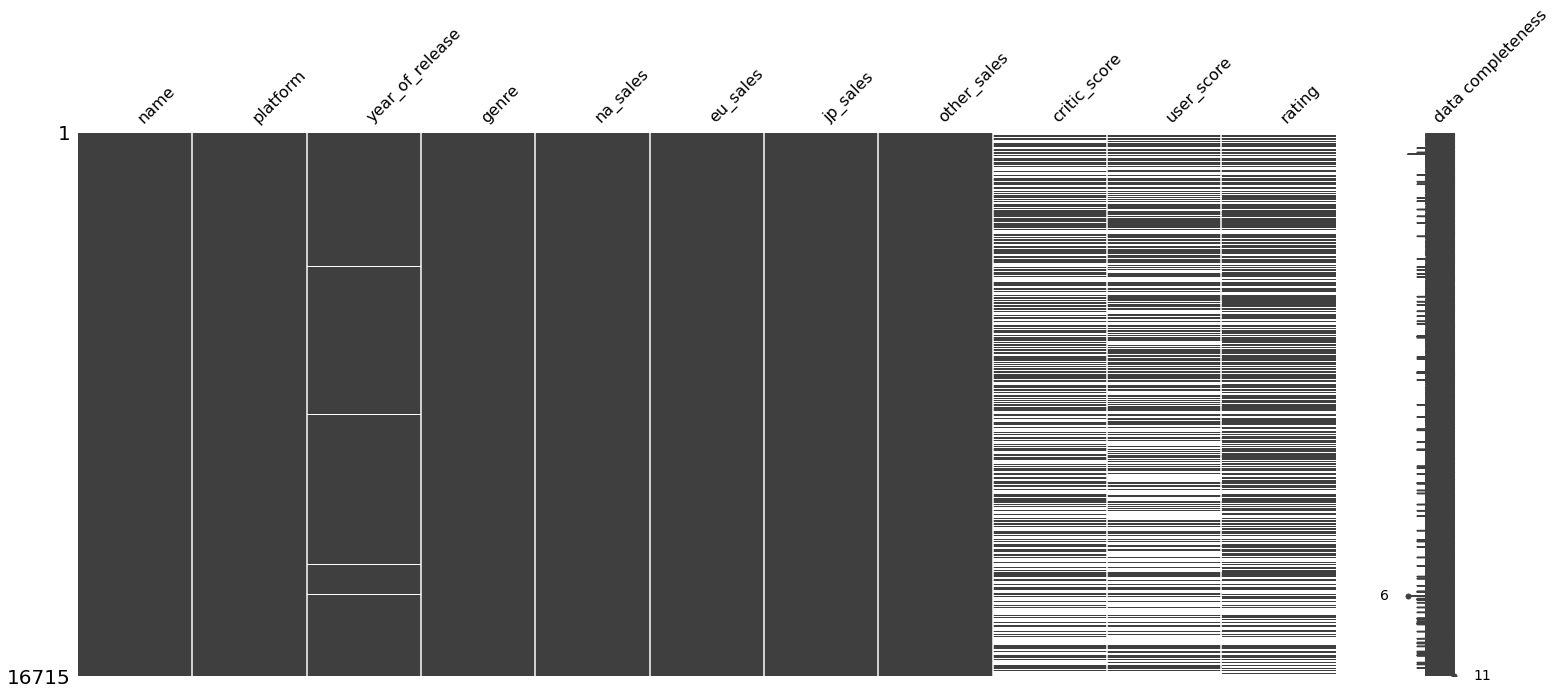

In [11]:
msno.matrix(data, labels=True);

На графике наглядно видно, что есть несколько пропусков в столбце с годом выпуска. Много значений пропущено в столбцах с оценками критиков и пользователей, а также с рейтингом ESRB.

In [13]:
data.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         9125
rating             6766
dtype: int64

Избавимся от строк с отсутствующим названием и жанром.

In [14]:
data = data.dropna(subset=['name', 'genre'])

Это оказались одни и те же строки.

В столбце с рейтингом ESRB слишком много пропусков - это может повлиять на дальнейшее исследование. Заменим пустые значения на Unknown.

In [15]:
data['rating'] = data['rating'].fillna('Unknown')

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16444 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       7590 non-null   float64
 10  rating           16713 non-null  object 
dtypes: float64(7), object(4)
memory usage: 1.5+ MB


In [17]:
data['year_of_release'].value_counts().sort_index(ascending=True)

1980.0       9
1981.0      46
1982.0      36
1983.0      17
1984.0      14
1985.0      14
1986.0      21
1987.0      16
1988.0      15
1989.0      17
1990.0      16
1991.0      41
1992.0      43
1993.0      60
1994.0     121
1995.0     219
1996.0     263
1997.0     289
1998.0     379
1999.0     338
2000.0     350
2001.0     482
2002.0     829
2003.0     775
2004.0     762
2005.0     939
2006.0    1006
2007.0    1197
2008.0    1427
2009.0    1426
2010.0    1255
2011.0    1136
2012.0     653
2013.0     544
2014.0     581
2015.0     606
2016.0     502
Name: year_of_release, dtype: int64

Данные собраны за период с 1980 по 2016 год. Заменим пропуски в столбце с годом выпуска на 1900. Информация о годе выпуска записана в формате float64, заменим тип данных на datetime.

In [18]:
data['year_of_release'] = data['year_of_release'].fillna(1900)
data['year_of_release'] = pd.to_datetime(data['year_of_release'], format='%Y').dt.year

Т.к. данные для датафрейма были собраны из открытых источников, то пропущенные значения в оценке игры пользоватлеями и критиками могут быть вызваны отстутсвием или недостаточным количеством информации. Для избежания искажения дальнейшего исследования оставим пропуски без изменений. 

Рейтинг ESRB может быть пропущен по той причине, что его просто нет для данной игры. ESRB работает на территории США и Канады. Для полноты данных, возможно, стоило учесть рейтинги европейской, японской и других систем оценок. Заполнять эти пропуски какими-либо значениями будет некорректно.

### Суммарные продажи

In [19]:
#посчитаем суммарные продажи во всех регионах и запишим их в новый столбец sum_sales
data['sum_sales'] = data['na_sales']+data['eu_sales']+data['jp_sales']+data['other_sales']

<a id="eda"></a>
## Исследовательский анализ данных

### Выбор актуального периода для анализа

Посмотрим, сколько игр выпускалось в разные годы. 

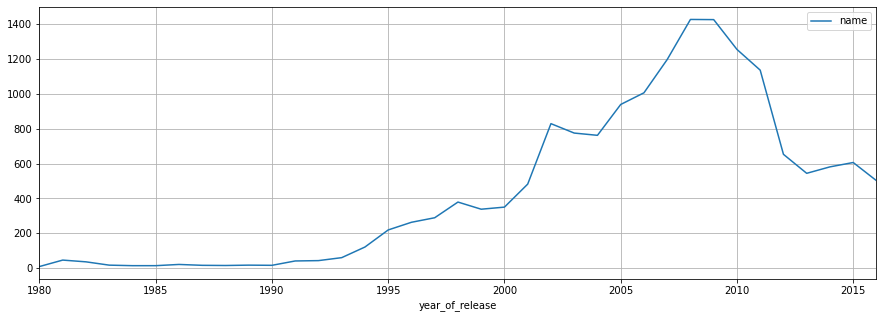

In [20]:
(
    data.pivot_table(index='year_of_release', values='name', aggfunc='count')\
    .plot(xlim=(1980, 2016), grid=True, figsize=(15, 5))
);

На графике видны всплески в 1998 и 2002 годах, но настоящий прорыв был в 2008-2009 годах, когда количество игр увеличилось почти в полтора раза по сравнению с прошлыми годами. Дальнейший спад в производстве игр, скорее всего, вызван последствиями экономического кризиса, пришедшегося как раз на эти годы (2008-2009), и реорганизацией всей индустрии. По этой причине для анализа и определения тенденций на игровом рынке лучше брать отрезок времени после 2009 года, хорошо отображающий новые условия и период восстановления после кризиса.

Посмотрим на количество проданных игр на разных платформах по годам.

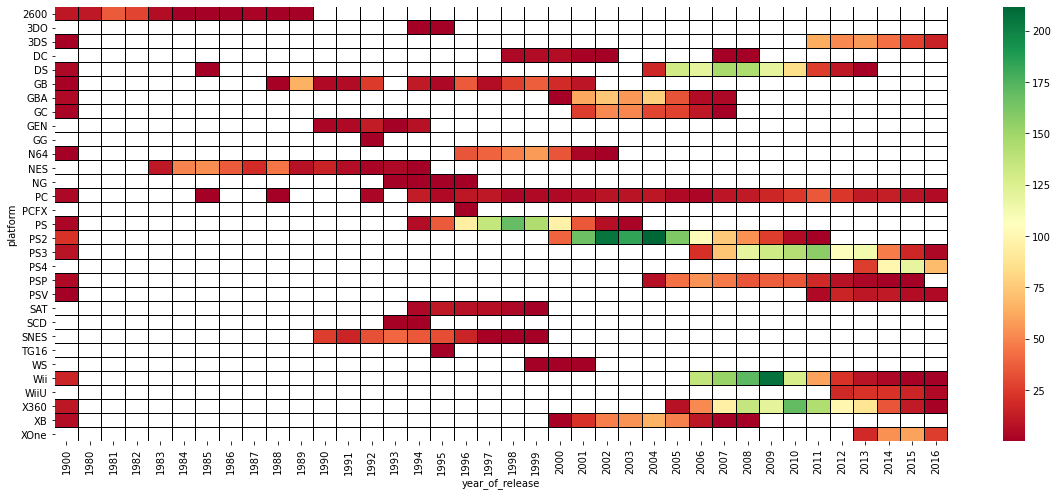

In [22]:
platform_sales_by_years = data.pivot_table(index='platform', columns = 'year_of_release', values='sum_sales', aggfunc='sum')
plt.figure(figsize = (20, 8))
sns.heatmap(platform_sales_by_years, cmap='RdYlGn', linewidth=0.01, linecolor='black');

Лидерами продаж за все года являются DS и Wii от Nintendo, 4 версии PS и X360. 

Интересен жизненный цикл PS - с выпуском новой версии сокращаются продажи игр для предыдущей платформы. Срок службы платформы - около 10 лет. При этом новая выпускается через 6-7 лет после выпуска прошлой. На графике у PS4 еще не так заметен рост продаж, это вызвано небольшим промежутком времени с момента выпука до сбора информации для исследования и малым количеством данных.

Для всех платформ характерно постепенное увеличение количества продаж, но не для Wii. Эта платформа сразу покорила мир, показав быстрый старт продаж с более 125 млн копий в год. Спад в продажах начинается с момента запуска наследницы - WiiU, которая на момент сбора данных не смогла повторить успех своей предшественницы.

Для дальнейшего анализа возьмем данные за 2012-2016 года.

In [23]:
actual_data = data.query('2012<=year_of_release<=2016')
actual_data.head(10)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sum_sales
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,Unknown,14.63
33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,Unknown,14.60
34,Call of Duty: Black Ops II,PS3,2012,Shooter,4.99,5.73,0.65,2.42,83.0,5.3,M,13.79
35,Call of Duty: Black Ops II,X360,2012,Shooter,8.25,4.24,0.07,1.12,83.0,4.8,M,13.68
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62
47,Pokemon Omega Ruby/Pokemon Alpha Sapphire,3DS,2014,Role-Playing,4.35,3.49,3.10,0.74,NaN,NaN,Unknown,11.68
60,Call of Duty: Ghosts,X360,2013,Shooter,6.73,2.56,0.04,0.91,73.0,2.6,M,10.24
62,New Super Mario Bros. 2,3DS,2012,Platform,3.66,3.14,2.47,0.63,78.0,7.2,E,9.90


### Платформы-лидеры

Посмотрим на прибыльность платформ в новом отрезке времени.

In [24]:
actual_platform_sales_by_years = actual_data.pivot_table(index='year_of_release', columns = 'platform', values='sum_sales', aggfunc='sum')
actual_platform_sales_by_years

platform,3DS,DS,PC,PS3,PS4,PSP,PSV,Wii,WiiU,X360,XOne
year_of_release,,,,,,,,,,,
2012,51.36,11.01,23.22,107.36,NaN,7.69,16.19,21.71,17.56,99.74,NaN
2013,56.57,1.54,12.38,113.25,25.99,3.14,10.59,8.59,21.65,88.58,18.96
2014,43.76,NaN,13.28,47.76,100.00,0.24,11.90,3.75,22.03,34.74,54.07
2015,27.78,NaN,8.52,16.82,118.90,0.12,6.25,1.14,16.35,11.96,60.14
2016,15.14,NaN,5.25,3.60,69.25,NaN,4.25,0.18,4.60,1.52,26.15


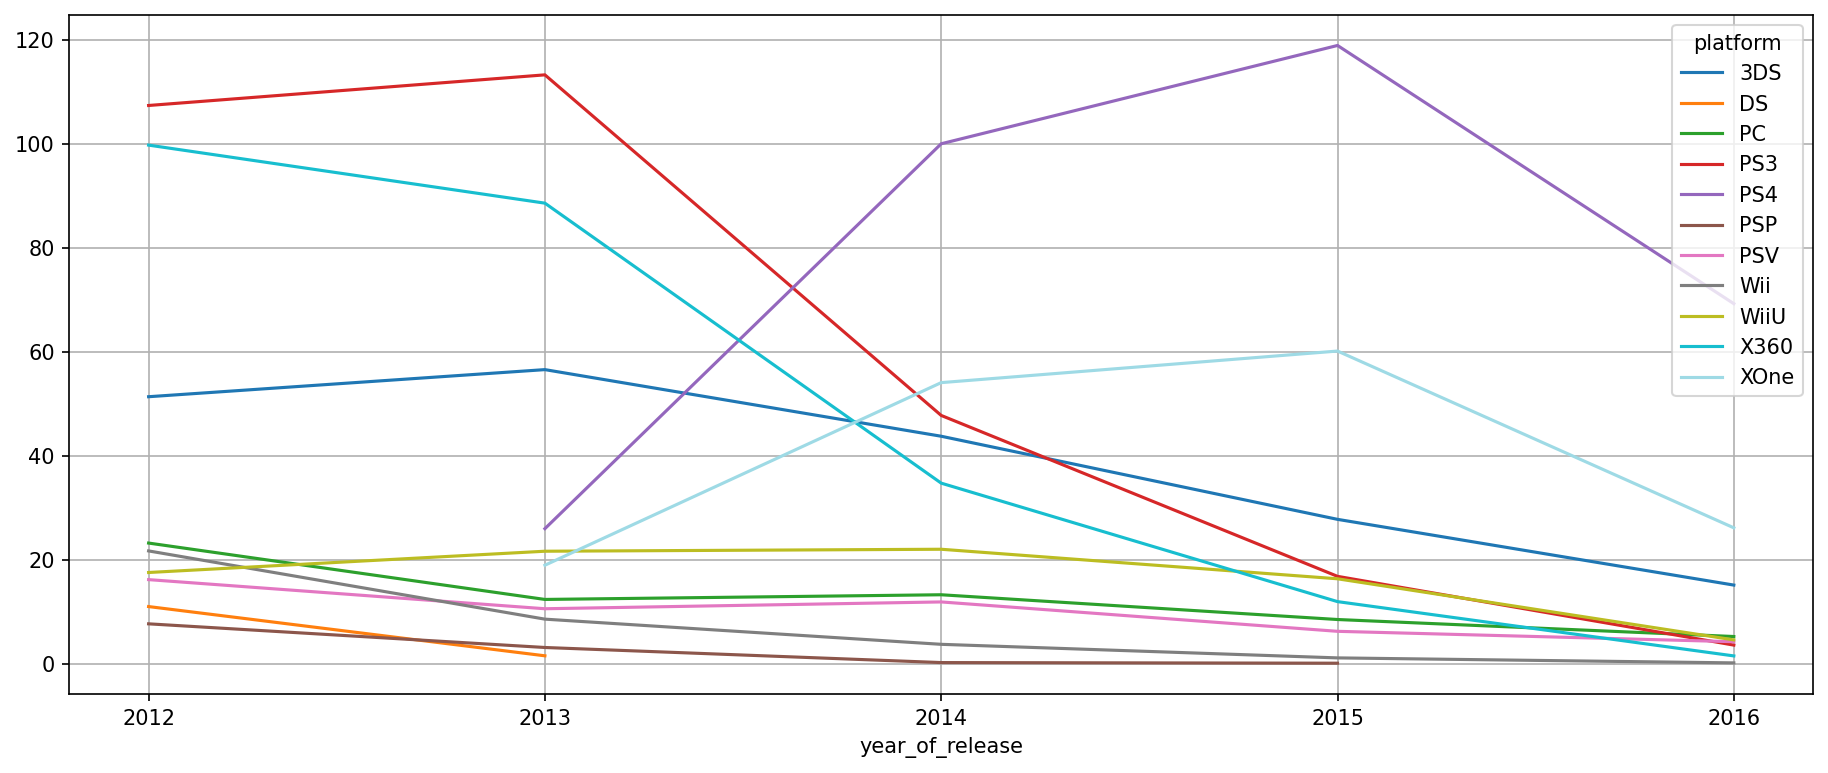

In [25]:
import matplotlib.ticker as ticker
fig, ax = plt.subplots(figsize=(15, 6), dpi=150)

actual_platform_sales_by_years.plot(cmap='tab20', grid=True, ax=ax)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))

Высокий уровень продаж показывали PS3 и X360, но после 2013 года пошли на убыль. В тот же год запускаются и набирают популярность их преемники - PS4 и XOne. Остальные платформы последних лет стабильно держатся примерно на одном уровне.

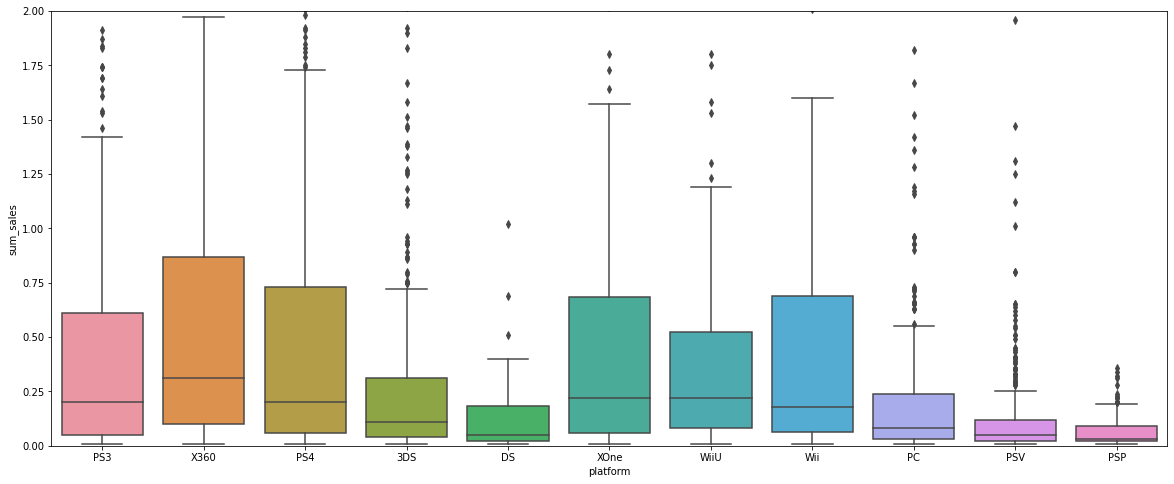

In [26]:
plt.figure(figsize = (20, 8))
plt.ylim([0, 2])
sns.boxplot(data = actual_data, x='platform', y='sum_sales');

На графике видно, что к указанным ранее лидерам можно добавить еще платформы WiiU и Wii. 

### Зависимость продаж от отзывов

Посмотрим, как влияют на уровень продаж отзывы пользователей и критиков на примере платформы X360.

In [28]:
actual_data_x360 = actual_data.query('platform=="X360"')

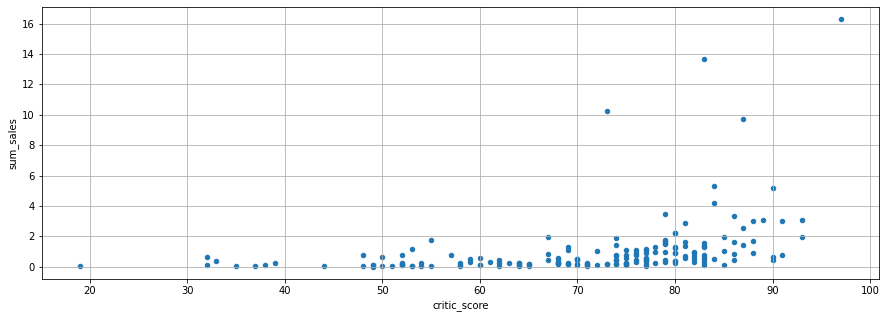

In [29]:
#построим график отношения продаж к оценке критиков
actual_data_x360.plot(x='critic_score', y='sum_sales', kind='scatter', grid=True, figsize=(15, 5));

In [30]:
#посмотрим корреляцию этих двух показателей
actual_data_x360['critic_score'].corr(actual_data_x360['sum_sales'])

0.3605734888507336

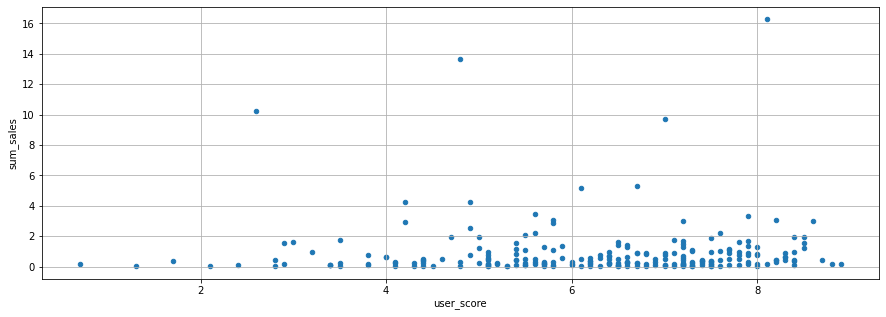

In [31]:
#построим график отношения продаж к оценке пользователей
actual_data_x360.plot(x='user_score', y='sum_sales', kind='scatter', grid=True, figsize=(15, 5));

In [32]:
#посмотрим корреляцию этих двух показателей
actual_data_x360['user_score'].corr(actual_data_x360['sum_sales'])

0.006163978646213326

По графикам видно, что игры с более высоким рейтингом среди критиков и других пользователей продаются чаще. Стоит отметить, что оценке критиков доверяют больше - среди игр с оценкой меньше 70 баллов нет выбросов. А вот на отзывы других игроков покупатели не так сильно ориетируются - некоторые игры "выстреливали" и с рейтингом около 4 баллов по 10-бальной шкале.

Корреляция в 0.36 в первом случае говорит о наличии слабой линейной связи между уровнем продаж и оценками критиков. В случае с оценками пользователей связь практически отсутствует.

Проверим эти выводы на продажах игр на других популярных платформах.

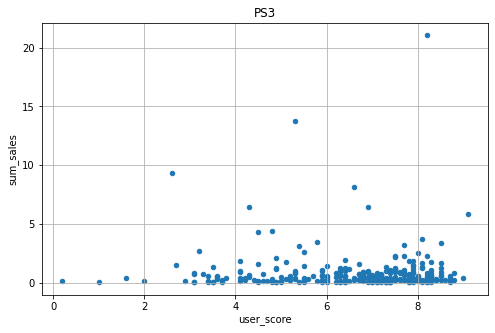

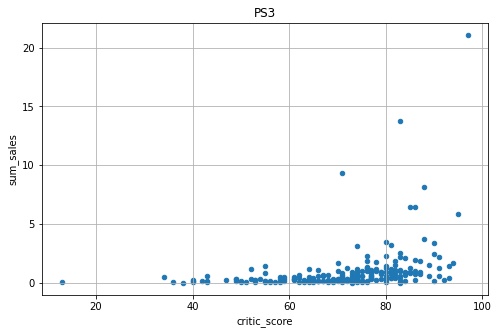

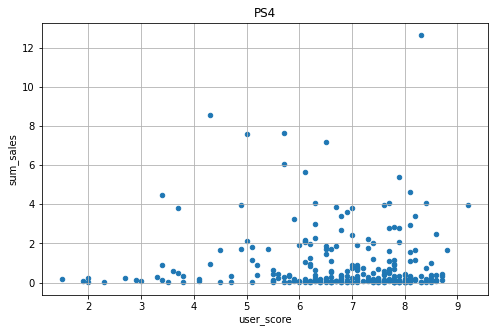

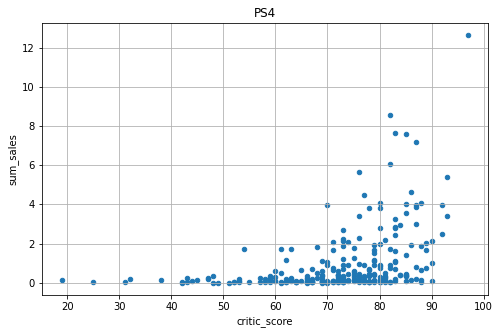

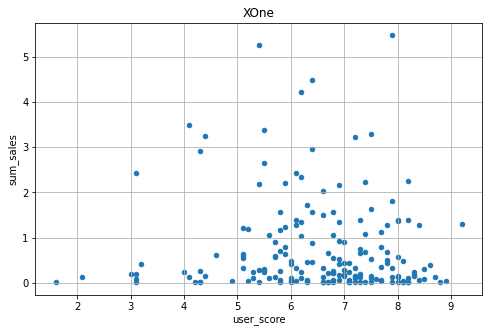

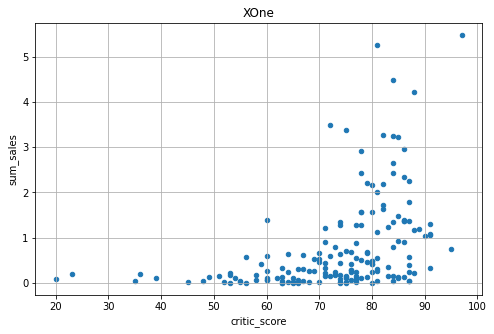

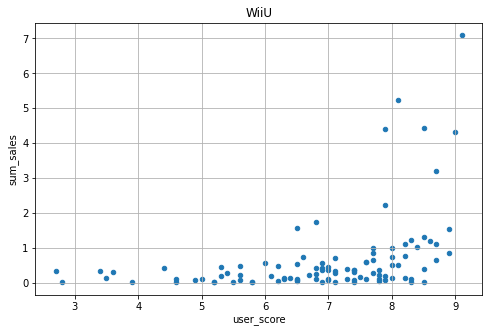

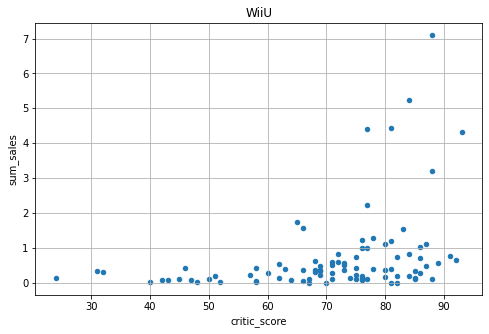

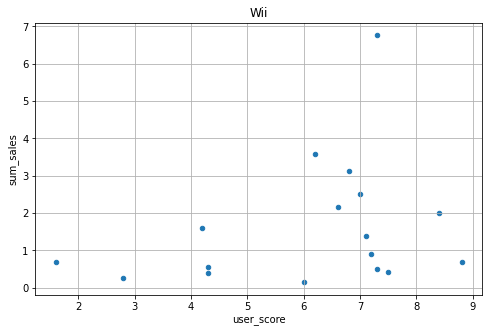

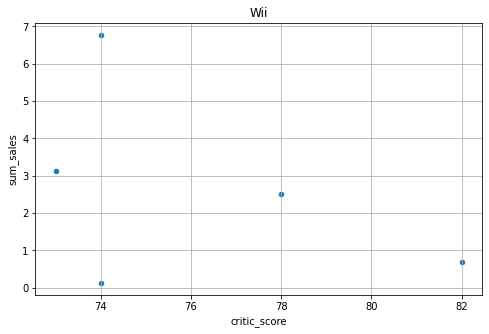

In [33]:
top_platforms = ['PS3', 'PS4', 'XOne', 'WiiU', 'Wii']
for p in top_platforms:
    actual_data_p = actual_data.query('platform==@p')
    actual_data_p.plot(x='user_score', y='sum_sales', kind='scatter', grid=True, figsize=(8, 5), title=p);
    actual_data_p.plot(x='critic_score', y='sum_sales', kind='scatter', grid=True, figsize=(8, 5), title=p);

In [34]:
top_platforms = ['PS3', 'PS4', 'XOne', 'WiiU', 'Wii']
for p in top_platforms:
    actual_data_p = actual_data.query('platform==@p')
    print('Коэффициент корреляции продаж и оценки критиков для', p, actual_data_p['critic_score'].corr(actual_data_p['sum_sales']))
    print('Коэффициент корреляции продаж и оценки пользователей для', p, actual_data_p['user_score'].corr(actual_data_p['sum_sales']))
    print('')

Коэффициент корреляции продаж и оценки критиков для PS3 0.3314972592629587
Коэффициент корреляции продаж и оценки пользователей для PS3 -0.005143522887113828

Коэффициент корреляции продаж и оценки критиков для PS4 0.40656790206178095
Коэффициент корреляции продаж и оценки пользователей для PS4 -0.031957110204556376

Коэффициент корреляции продаж и оценки критиков для XOne 0.4169983280084017
Коэффициент корреляции продаж и оценки пользователей для XOne -0.06892505328279414

Коэффициент корреляции продаж и оценки критиков для WiiU 0.34837976012017485
Коэффициент корреляции продаж и оценки пользователей для WiiU 0.4002190202148617

Коэффициент корреляции продаж и оценки критиков для Wii -0.4243413011077494
Коэффициент корреляции продаж и оценки пользователей для Wii 0.29619680007479526



Выводы подтвердились. Высокий уровень продаж показывают игры с хорошими оценками. Пользователи "Wii" и "WiiU" больше доверяют оценкам других игроков, чем фанаты PlayStation и Xbox - те готовы покупать игры даже со средними отзывами.

### Жанры игры

Посмотрим на данные с точки зрения жанра игры.

In [35]:
#выведем количество выпускаемых игр в разных жанрах
actual_data['genre'].value_counts()

Action          1031
Role-Playing     370
Adventure        302
Sports           268
Shooter          235
Misc             192
Racing           115
Fighting         109
Platform          85
Simulation        80
Strategy          71
Puzzle            28
Name: genre, dtype: int64

Лидируют с большим отрывом боевики, на втором месте - РПГ, на третьем - приключенческие игры.

Посмотрим, совпадает ли это распределение с продажами игр по жанрам. Изучим медианное значение в каждом жанре.

In [36]:
actual_data.groupby('genre')['sum_sales'].median().sort_values(ascending=False)

genre
Shooter         0.440
Sports          0.240
Platform        0.210
Role-Playing    0.140
Racing          0.140
Fighting        0.130
Action          0.120
Misc            0.120
Simulation      0.120
Strategy        0.080
Puzzle          0.045
Adventure       0.030
Name: sum_sales, dtype: float64

Наибольшим количеством копий продаются шутеры, за ними в тройку лидеров входят платформеры и спортивные симуляторы. Что касается экшенов - их хоть и выпускают значительно больше, чем любых других игр, но по отдельности они приносят совсем небольшой доход.

<a id="portrait"></a>
## Портрет пользователя по регионам

Составим на основе данных портрет пользователя для трех регионов - Северной Америки, Европы и Японии.

### Топовые платформы

В первую очередь посмотрим на топ-5 платформ в каждом регионе.

In [37]:
na_top = pd.DataFrame(actual_data.groupby('platform')['na_sales'].sum().sort_values(ascending=False).head())
na_top.columns = ['Северная Америка']

In [38]:
eu_top = pd.DataFrame(actual_data.groupby('platform')['eu_sales'].sum().sort_values(ascending=False).head())
eu_top.columns = ['Европа']

In [39]:
jp_top = pd.DataFrame(actual_data.groupby('platform')['jp_sales'].sum().sort_values(ascending=False).head())
jp_top.columns = ['Япония']

In [40]:
top_region_platforms = na_top.join([eu_top, jp_top], how='outer')
top_region_platforms

,Северная Америка,Европа,Япония
platform,,,
X360,140.05,74.52,NaN
PS4,108.74,141.09,15.96
PS3,103.38,106.86,35.29
XOne,93.12,51.59,NaN
3DS,55.31,42.64,87.79
PSV,NaN,NaN,21.04
WiiU,NaN,NaN,13.01


Топ платформ в Европе и Северной Америке схожи за одним исключением - в Европе вместо XOne в пятерку входит PC. В Америке максимальную прибыль приносит родная консоль Xbox, в то время как европейцы отдают предпочтение японской PlayStation.

Интересно распределение платформ в Японии - значительно отличается от других регионов. Здесь более популярными являются портативные консоли. Также надо отметить, что в топ-5 платформ в Японии вошли только консоли местных корпораций - Sony и Nintendo. 

### Топовые жанры

Теперь посмотрим, какие жанры популярны в разных регионах.

In [43]:
na_genre = pd.DataFrame(actual_data.groupby('genre')['na_sales'].sum().sort_values(ascending=False).head())
na_genre.columns = ['Северная Америка']

In [44]:
eu_genre = pd.DataFrame(actual_data.groupby('genre')['eu_sales'].sum().sort_values(ascending=False).head())
eu_genre.columns = ['Европа']

In [45]:
jp_genre = pd.DataFrame(actual_data.groupby('genre')['jp_sales'].sum().sort_values(ascending=False).head())
jp_genre.columns = ['Япония']

In [46]:
top_region_genres = na_genre.join([eu_genre, jp_genre], how='outer')
top_region_genres

,Северная Америка,Европа,Япония
genre,,,
Action,177.84,159.34,52.80
Shooter,144.77,113.47,NaN
Sports,81.53,69.09,NaN
Role-Playing,64.00,48.53,65.44
Misc,38.19,NaN,12.86
Racing,NaN,27.29,NaN
Simulation,NaN,NaN,10.41
Fighting,NaN,NaN,9.44


Северная Америка и Европа имеют практически одинаковые предпочтения в играх, чего не сказать о японцах. Отличия в культуре и менталитете сказываются и на игровых пристрастиях - здесь на первое место вышли ролевые игры, а также вошли в топ симуляторы и файтинги.

### Влияние рейтинга ESRB

Проверим, влияет ли наличие рейтинга ESRB на продажи игр.

In [47]:
na_rating = pd.DataFrame(actual_data.groupby('rating')['na_sales'].sum().sort_values(ascending=False))
na_rating.columns = ['Северная Америка']

In [48]:
eu_rating = pd.DataFrame(actual_data.groupby('rating')['eu_sales'].sum().sort_values(ascending=False))
eu_rating.columns = ['Европа']

In [49]:
jp_rating = pd.DataFrame(actual_data.groupby('rating')['jp_sales'].sum().sort_values(ascending=False))
jp_rating.columns = ['Япония']

In [50]:
total_rating = na_rating.join([eu_rating, jp_rating], how='outer')
total_rating

,Северная Америка,Европа,Япония
rating,,,
M,231.57,193.96,21.20
E,114.37,113.03,28.33
Unknown,103.31,91.50,108.84
E10+,75.70,55.37,8.19
T,66.02,52.96,26.02


В Америке и Европе больше всего продано игр с рейтингом M - Mature (для лиц старше 17 лет), на втором месте игры с отметкой E - Everyone (подходящие для всех). Напомним, что Unknown - это заглушка для пропущенных значений. Игры без рейтинга входят в тройку лидеров по продажам, а в Японии и вовсе стоят на первом месте. Но это не значит, что японцы отдают предпочтение играм без указанной возврастной категории. Скорее всего внутри страны действует своя система оценки, на которую и ориентируются покупатели.

<a id="hypotheses"></a>
## Проверка гипотез

### Гипотеза 1

Проверим следующую гипотезу:

Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

Для проверки гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам используем специальны t-тест.

In [51]:
#нулевая гипотеза - Средние пользовательские рейтинги платформ Xbox One и PC равны
#альтернативная гипотеза - Средние пользовательские рейтинги платформ Xbox One и PC не равны

xbox_rate = actual_data.query('platform=="XOne" and user_score>=0')['user_score']
pc_rate = actual_data.query('platform=="PC" and user_score>=0')['user_score']
alpha = 0.5
results = st.ttest_ind(xbox_rate, pc_rate)
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 0.5535080500643661
Не получилось отвергнуть нулевую гипотезу


Результат теста показал, что действительно пользователи примено одинаково оценивают игры на платформе Xbox One и на PC. Р-значение 99% говорит о практически полном совпадении рейтингов.

### Гипотеза 2

Проверим следующую гипотезу:

Средние пользовательские рейтинги жанров Action и Sports разные.

Здесь также используем t-тест.

In [52]:
#нулевая гипотеза - Средние пользовательские рейтинги жанров Action и Sports равны
#альтернативная гипотеза - Средние пользовательские рейтинги жанров Action и Sports не равны

action_rate = actual_data.query('genre=="Action" and user_score>=0')['user_score']
sports_rate = actual_data.query('genre=="Sports" and user_score>=0')['user_score']
alpha = 0.5
results = st.ttest_ind(action_rate, sports_rate)
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 3.7163089460934874e-26
Отвергаем нулевую гипотезу


Нулевая гипотеза отвергнута по итогам теста. Это означает, что вступает в силу альтернативная гипотеза, подтверждающая наш изначальный вопрос - средние пользовательские рейтинги жанров Action и Sports разные.

## Общий вывод

**В ходе исследования** были изучены 16715 записей о продажах игр до 2016 года, оценках пользователей и экспертов, жанрах и платформах. Были исследованы определяющие успешность игры закономерности.

**На этапе предоработки** названия столбцов и типы данных были приведены к общепринятым и корректным. Были обнаружены пропуски в столбцах с оценками критиков и пользователей, а также с рейтингом ESRB. Пропущенный рейтинг был заменен заглушкой "Unknown". Отсутствующий год был исправлен на "1900".

Во время **исследовательского анализа** были изучены топовые платформы, жанры игр, зависимость продаж от оценок. На этапе выбора актуального для анализа временного периода были сделаны **следующие выводы**:
- После долгого роста и достижения пика в 2008-2009 годах производство игр пошло на убыль. Скорее всего, причиной тому стал экономический кризис.
- Лидерами продаж за все года являются DS и Wii от Nintendo, 4 версии PS и X360.

**Для дальнейшего анализа были взяты данные за 2012-2016 гг.** В этот период:
- Высокий уровень продаж показывали PS3 и X360, после 2013 года уступив место следующим версиям - PS4 и XOne.
- Пользователи полагаются на оценки критиков при выборе игры, и реже доверяют оценкам других игроков.
- Больше всего выпускается игр в жанре экшен, однако, среди самых продаваемых лидируют шутеры.

На основе данных были составлены **портреты пользователей** для следующих регионов: Северная Америка, Европа и Япония. Изучались такие параметры: выбор платформы, выбор жанра, влияние рейтинга ESRB. **Американцы и европейцы за небольшими исключениями имеют схожие предпочтения в платформах и жанрах. Заметные отличия присутствуют у японской аудитории** - здесь чаще выбирают портативные консоли отечественного производства. Культурные отличия влияют и на выбор любимого жанра - в Японии лидирует РПГ, в то время как два других региона предпочитают шутеры. Игры без рейтинга входят в тройку лидеров по продажам, а в Японии и вовсе стоят на первом месте. Скорее всего внутри страны действует своя система оценки, на которую и ориентируются покупатели.

Было проверено **две гипотезы**. Результаты тестов показали следующее:
- пользователи примено одинаково оценивают игры на платформе Xbox One и на PC
- средние пользовательские рейтинги жанров Action и Sports разные.